# Assign 1 - Deep Learning
Jonathan Menahem - 203772611 <br>
Alon Mazri - 

Help Source: [https://www.analyticsvidhya.com/blog/2020/09/pneumonia-detection-using-cnn-with-implementation-in-python/](https://www.analyticsvidhya.com/blog/2020/09/pneumonia-detection-using-cnn-with-implementation-in-python/)

In [1]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras import layers
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten

In [2]:
import tensorflow as tf

print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Exploring The Data

In [3]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras import layers
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten


In [4]:
# Identify Image Resolutions

# Import Packages
import pandas as pd
import matplotlib.pyplot  as plt
from PIL import Image
from pathlib import Path
import imagesize
import numpy as np

# Get the Image Resolutions
root_path = 'chest_xray\\train\\NORMAL\\'
imgs = [img.name for img in Path(root_path).iterdir() if img.suffix == ".jpeg"]
img_meta = {}
for f in imgs: img_meta[str(f)] = imagesize.get(root_path+f)

# Convert it to Dataframe and compute aspect ratio
img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

print(f'Total Nr of Images in the dataset: {len(img_meta_df)}')
img_meta_df.head()

Total Nr of Images in the dataset: 1349


,FileName,Size,Width,Height,Aspect Ratio
0,IM-0115-0001.jpeg,"(2090, 1858)",2090,1858,1.12
1,IM-0117-0001.jpeg,"(1422, 1152)",1422,1152,1.23
2,IM-0119-0001.jpeg,"(1810, 1434)",1810,1434,1.26
3,IM-0122-0001.jpeg,"(1618, 1279)",1618,1279,1.27
4,IM-0125-0001.jpeg,"(1600, 1125)",1600,1125,1.42


Text(0, 0.5, 'Height')

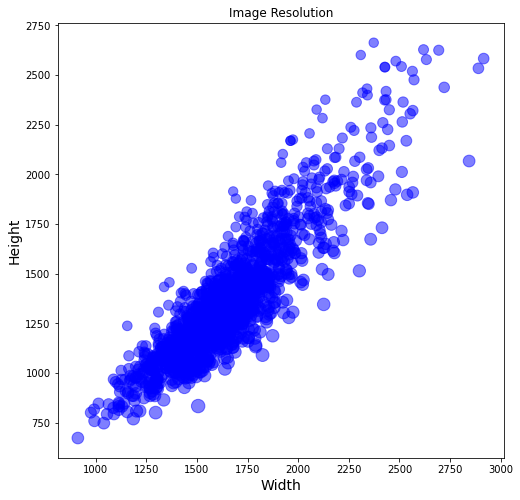

In [5]:
# Visualize Image Resolutions

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(img_meta_df.Width, img_meta_df.Height, color='blue', alpha=0.5, s=img_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)

# Loading The Data

In [6]:
train_directory = 'chest_xray/train'

# these are all default input values from documentation
train_data = tf.keras.utils.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(256,
    256), shuffle=True, seed=3, validation_split=0.15, subset='training',
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(256,
    256), shuffle=True, seed=3, validation_split=0.15, subset='training',
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)

test_directory = 'chest_xray/test'

# these are all default input values from documentation
test_data = tf.keras.utils.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(256,
    256), shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)

Found 5232 files belonging to 2 classes.
Using 4448 files for training.
Found 5232 files belonging to 2 classes.
Using 4448 files for training.
Found 624 files belonging to 2 classes.


In [7]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32, 2)


In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
num_classes = 2
input_shape = (256, 256, 3)

basic_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Dense(50, activation="relu"),
        layers.Dense(25, activation="relu"),
        layers.Dense(12, activation="relu"),
        layers.Flatten(),
        layers.Dropout(0.1),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [11]:
basic_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256, 256, 50)      200       
                                                                 
 dense_1 (Dense)             (None, 256, 256, 25)      1275      
                                                                 
 dense_2 (Dense)             (None, 256, 256, 12)      312       
                                                                 
 flatten (Flatten)           (None, 786432)            0         
                                                                 
 dropout (Dropout)           (None, 786432)            0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1572866   
                                                                 
Total params: 1,574,653
Trainable params: 1,574,653
Non-

In [12]:
basic_model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

In [13]:
epochs = 15

basic_history = basic_model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/15
139/139 [==============================] - 15s 97ms/step - loss: 130.2486 - accuracy: 0.8237 - val_loss: 0.6897 - val_accuracy: 0.8993
Epoch 2/15
139/139 [==============================] - 11s 79ms/step - loss: 0.4888 - accuracy: 0.9092 - val_loss: 0.2087 - val_accuracy: 0.9206
Epoch 3/15
139/139 [==============================] - 11s 80ms/step - loss: 0.2086 - accuracy: 0.9231 - val_loss: 0.2005 - val_accuracy: 0.9227
Epoch 4/15
139/139 [==============================] - 11s 76ms/step - loss: 0.1981 - accuracy: 0.9258 - val_loss: 0.1894 - val_accuracy: 0.9269
Epoch 5/15
139/139 [==============================] - 11s 77ms/step - loss: 0.1863 - accuracy: 0.9330 - val_loss: 0.1763 - val_accuracy: 0.9310
Epoch 6/15
139/139 [==============================] - 11s 77ms/step - loss: 0.1740 - accuracy: 0.9364 - val_loss: 0.1628 - val_accuracy: 0.9373
Epoch 7/15
139/139 [==============================] - 11s 78ms/step - loss: 0.1610 - accuracy: 0.9391 - val_loss: 0.1510 - val_accurac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


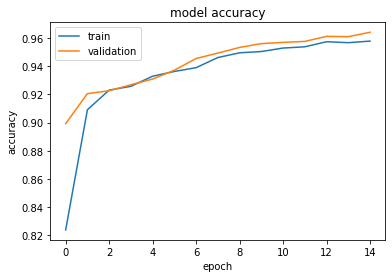

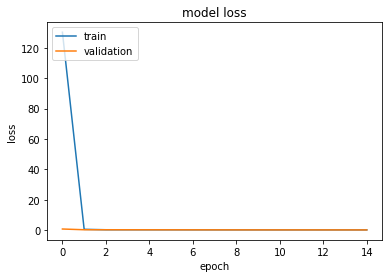

In [14]:
# list all data in history
print(basic_history.history.keys())
# summarize history for accuracy
plt.plot(basic_history.history['accuracy'])
plt.plot(basic_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(basic_history.history['loss'])
plt.plot(basic_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()